In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

import numpy as np
import cupy as cp
np.set_printoptions(threshold=np.inf)

import time
import random
import pylab
import time, sys

from IPython.display import clear_output
from random import randrange
from hrr import *

seed = 45
random.seed(seed)
np.random.seed(seed)

In [2]:
live_graph = False

# Number of training cycles
episodes = 100000

# Hrr parameters
hrr_length = 15000
normalized = True

# How many steps to take before quiting
steps_till_quit = 300

signals = ["R", "G"]
goals = [[0, 5], [10, 15]]

# Maze parameters
size_of_maze = 20
non_obs_task_switch_rate = 1000
num_non_obs_tasks = 2
num_obs_tasks = len(signals)

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.9
alpha = 0.1

# Reward for temporal difference learning
reward_bad = -1
reward_good = 0

# Expolration rate
e_soft = 0.00001
rand_on = 1

# Threshold for non observable task switching
# threshold = 0.5
# threshold_alpha = 0.001
threshold = 0.3


# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.0

# Neural network
weights = hrr(hrr_length, normalized)
bias = 1

percent_check = 9

non_obs = 0
current_atr = 0
current_wm = "I"

debug = False
debug2 = False

step_store = []
pos_err_store = []
neg_err_store = []
total_error = []
total_goal_error = []
switch_error = []
norm_error = []


ltm = LTM(hrr_length, normalized)

if live_graph:
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "g", "b", "y"]) 

In [3]:
def update_progress(progress, episode):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Episode {0}, Progress: [{1}] {2:.1f}%".format(episode, "=" * block + "." * (bar_length - block), progress * 100)
    print(text)

In [4]:
def get_moves(state, size_of_maze):
    if(state == 0):
        return size_of_maze - 1, 1
    elif(state == size_of_maze - 1):
        return size_of_maze - 2, 0
    else:
        return state - 1, state + 1

In [5]:
def build_hrr_string(wm, signal, state, atr):
    if wm == "I" and signal == "I":
        return "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif wm == "I":
        return "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif signal == "I":
        return "WM:" + str(wm) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    else:
        return "WM:" + str(wm) + "*" + "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)

In [6]:
def context_policy_negative(atr):
    return (atr + 1)%num_non_obs_tasks

In [7]:
def context_policy_positive(wm, signal, state, atr):
    val = -9999
    temp = -9999
    
    for atr in range(0, num_non_obs_tasks):
        encode_str = build_hrr_string(wm, signal, state, atr)
        temp = cp.dot(weights, ltm.encode(encode_str)) + bias
        if temp > val:
            val = temp
            s_atr = atr
            
    return s_atr

In [8]:
def move_policy(goal, moves, wms, signals, atr, rand_on):
    
    val = -9999
    temp = -9999
    
    for move in moves:
        for wm in list(dict.fromkeys(wms + ["I"])):
            for signal in list(dict.fromkeys(signals + ["I"])):
                if move == goal:
                    encode_str = build_hrr_string(wm, signal, str(move) + "*rewardTkn", atr)
                else:
                    encode_str = build_hrr_string(wm, signal, str(move), atr)
                if (debug):
                    print(encode_str)
                temp = cp.dot(weights, ltm.encode(encode_str)) + bias
                if debug:
                    if signal != "I":
                        print("Move: {0}, WM: {1}, Signal: {2}In, Atr: {3}, Value: {4}".format(move, wm, signal, atr, temp))
                    else:
                        print("Move: {0}, WM: {1}, Signal: {2}, Atr: {3}, Value: {4}".format(move, wm, signal, atr, temp))
                if temp > val:
                    val = temp
                    s_move = move
                    if signal != "I":
                        s_wm = signal + "In"
                    else:
                        s_wm = wm
            
    # Random move
    if(np.random.random_sample() < e_soft) and rand_on:
        if(debug):
            print("RANDOM MOVE")
        return (np.random.choice(moves), wm, atr, 1)
    
    return (s_move, s_wm, atr, 0)

In [9]:
def get_opt_steps(start, goal, size_of_maze):
    opt = abs(goal - start)
    if opt > size_of_maze / 2:
        opt = size_of_maze - opt
    return opt

In [10]:
def logmod(x):
    return np.sign(x)*np.log(abs(x)+1)

In [11]:
def animate(i):
    for x in range(num_non_obs_tasks):
        x_ind = x
        y_for_no_rwd = 0
        for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
            position = np.arange(size_of_maze)
            value = np.zeros(size_of_maze)
            for signal in list(dict.fromkeys(signals + ["I"])):
                for state in range(size_of_maze):
                    encode_str = build_hrr_string(wm, signal, str(state), x)
                    value[state] = cp.dot(weights, ltm.encode(encode_str)) + bias
                axes[x_ind,y_for_no_rwd].clear
                axes[x_ind,y_for_no_rwd].plot(position, value)
            y_for_no_rwd += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [12]:
if live_graph:
    fig, axes = plt.subplots(nrows=num_non_obs_tasks, ncols=num_obs_tasks+1)
    for x in range(num_non_obs_tasks):
        x_ind = x
        y_for_no_rwd = 0
        for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
            position = np.arange(size_of_maze)
            value = np.zeros(size_of_maze)
            for signal in list(dict.fromkeys(signals + ["I"])):
                lab = "WM:" + wm + "*Signal:" + signal + "*Atr:" + str(x)
                for state in range(size_of_maze):
                    encode_str = build_hrr_string(wm, signal, str(state), x)
                    value[state] = cp.dot(weights, ltm.encode(encode_str)) + bias
                axes[x_ind,y_for_no_rwd].title.set_text(wm + " Atr: " + str(x))
                axes[x_ind,y_for_no_rwd].plot(position, value,label=lab)
                axes[x_ind,y_for_no_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                      fancybox=True, shadow=True, ncol=1, prop={'size': 10})
            y_for_no_rwd += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    ani = animation.FuncAnimation(fig, animate, interval=60000)
    plt.show()
    plt.suptitle("{0} Non-Observable tasks and {1} Observable tasks with goals: {2}".format(num_non_obs_tasks, num_obs_tasks, goals), fontsize=30)

In [13]:
t0 = time.time()

In [14]:
for x in range(episodes):
        
    current_state = random.randint(0, size_of_maze - 1)
    start = current_state
    current_signal = np.random.choice(signals)
       
    if x%non_obs_task_switch_rate == 0:
        non_obs = (non_obs+1)%len(goals)
    if num_obs_tasks == 1:
        goal = goals[non_obs][0]
    else:
        goal = goals[non_obs][signals.index(current_signal)]
        
    steps = 0
    opt_steps = get_opt_steps(current_state, goal, size_of_maze)
    
    # Reset trace
    eligibility *= 0.0
    
    if debug2 == False and x > ((episodes*percent_check) / 10):
        debug2 = True
        rand_on = 0
        alpha = 0.01
    
    if debug:
        print("Goal: {0}, Signal: {1}, Non_Observable: {2}".format(goal, current_signal, non_obs))
        
    episode_memory = []
    for y in range(steps_till_quit):
        if (current_state == goal):
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)
            goal_hrr = ltm.encode(encode_str)
            goal_value = cp.dot(weights, goal_hrr) + bias
            episode_memory += [[current_state, goal_value, goal]]

            error = reward_good - goal_value
            eligibility *= eli_lambda
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * logmod(error) * eligibility))
            
            total_goal_error += [error]
            
            if(debug):
                print("In goal with value {0}".format(goal_value))
            
            break
            
        
        # Store info about previous state      
        previous_wm = current_wm
        previous_signal = current_signal
        previous_state = current_state
        previous_atr = current_atr
        
        if debug:
            print("Previous WM:, {0}, Signal:, {1}, State, {2}, ATR:, {3}".format(previous_wm, previous_signal, previous_state, previous_atr))
        
        encode_str = build_hrr_string(previous_wm, previous_signal, previous_state, previous_atr)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = cp.dot(weights, previous_state_hrr) + bias
        
        if debug:
            print("Started with state: {0}, State Value: {1}, WM: {2},  Atr: {3}".format(previous_state, previous_value, previous_wm, previous_atr))
            
        current_signal = "I"
        left, right = get_moves(previous_state, size_of_maze)
        if previous_signal != "I":
            previous_signal += "In"

        # Make the move
        move, wm, atr, random_move = move_policy(goal, [left, right], [previous_wm, previous_signal], [current_signal], previous_atr, rand_on)
        steps += 1
        
        current_wm = wm
        current_state = move
        current_atr = atr
        
        if random_move:
            eligibility *= 0.0
            
        if(debug):
            print("Moves {0}, taken {1}".format([left, right], move))
            
        if debug:
            print("Current WM {0}, Current Signal {1}, Current state {2}, Current ATR {3}".format(current_wm, current_signal, current_state, current_atr))
            
        if current_state == goal:
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)     
            if debug:
                print("In goal: WM: {1}, ATR: {2}".format(current_wm, current_atr))
        else:
            encode_str = build_hrr_string(current_wm, current_signal, current_state, current_atr)
            
        current_state_hrr = ltm.encode(encode_str)
        current_value = cp.dot(weights, current_state_hrr) + bias
        
        sarsa_error = (reward_bad + discount * current_value) - previous_value
#         threshold -= threshold_alpha * (np.sign(sarsa_error) * np.log(abs(sarsa_error) + 1))
        eligibility *= eli_lambda
        eligibility = eligibility + previous_state_hrr
        weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
        total_error += [sarsa_error]
        norm_error += [sarsa_error]
        if sarsa_error > threshold and num_non_obs_tasks > 0:
            switch_error += [sarsa_error]
            if debug2:
                pos_err_store += [sarsa_error]
            current_atr = context_policy_positive(current_wm, current_signal, current_state, current_atr)
            eligibility *= 0.0
            steps = 0
            start = current_state
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        if sarsa_error < -threshold and num_non_obs_tasks > 0:
            switch_error += [sarsa_error]
            if debug2:
                neg_err_store += [sarsa_error]
            current_atr = context_policy_negative(previous_atr)
            eligibility *= 0.0
            steps = 0
            start = current_state
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        
        if debug:
            input("")
            
    if debug2:
        if current_state == goal:
            step_store += [steps - opt_steps]
        else:
            step_store += [steps]
            
    update_progress(x / episodes, x)
    
    if live_graph:
        plt.pause(0.001)
    
update_progress(1, episodes)
plt.show()

Episode 100000, Progress: [==================================================] 100.0%


In [15]:
t1 = time.time()
print(t1-t0)

1164.6427438259125


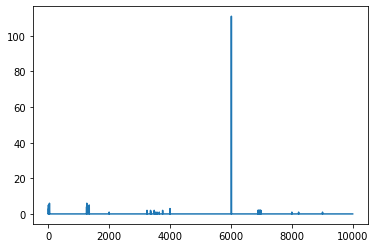

99.55995599559957


In [16]:
plt.plot(step_store)
plt.show()
accuracy = (len(step_store)-np.count_nonzero(step_store))*100.0 / len(step_store)
print(accuracy)

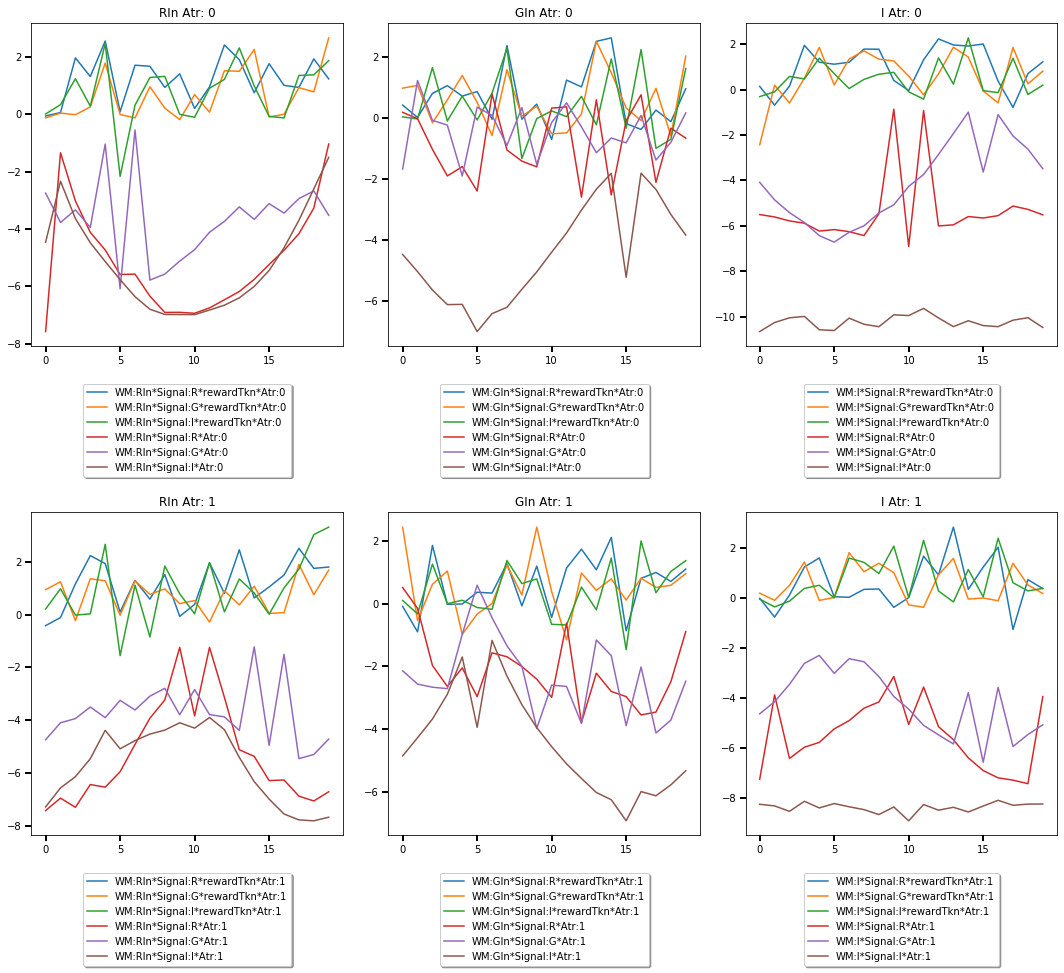

In [17]:
fig, axes = plt.subplots(nrows=num_non_obs_tasks, ncols=num_obs_tasks+1)
fig.set_figwidth(15)
fig.set_figheight(15)
plt.rcParams.update({'font.size': 14})

for x in range(num_non_obs_tasks):
    
    x_ind = x
    
    y_for_rwd = 0
    y_for_no_rwd = 0
    
    for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
        position = np.arange(size_of_maze)
        value = np.zeros(size_of_maze)
        for signal in signals + ["I"]:
            lab = "WM:" + wm + "*Signal:" + signal + "*rewardTkn*Atr:" + str(x)
            for state in range(size_of_maze):
                encode_str = build_hrr_string(wm, signal, str(state) + "*rewardTkn", x)
                value[state] = cp.dot(weights, ltm.encode(encode_str)) + bias
            axes[x_ind,y_for_rwd].title.set_text(wm + " with rewardTkn " + "Atr: " + str(x))
            axes[x_ind,y_for_rwd].plot(position, value, label=lab)
            axes[x_ind,y_for_no_rwd].tick_params(direction='out', length=6, width=2,
               grid_color='r', grid_alpha=0.5)
            axes[x_ind,y_for_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=True, ncol=1, prop={'size': 10})
        y_for_rwd += 1
        
        y = x + 1
        value = np.zeros(size_of_maze)
        for signal in list(dict.fromkeys(signals + ["I"])):
            lab = "WM:" + wm + "*Signal:" + signal + "*Atr:" + str(x)
            for state in range(size_of_maze):
                encode_str = build_hrr_string(wm, signal, str(state), x)
                value[state] = cp.dot(weights, ltm.encode(encode_str)) + bias
            axes[x_ind,y_for_no_rwd].title.set_text(wm + " Atr: " + str(x))
            axes[x_ind,y_for_no_rwd].plot(position, value, label=lab)
            axes[x_ind,y_for_no_rwd].tick_params(direction='out', length=6, width=2,
               grid_color='r', grid_alpha=0.5)
            axes[x_ind,y_for_no_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=True, ncol=1, prop={'size': 10})
        y_for_no_rwd += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('combined.png', dpi=500)
plt.show()

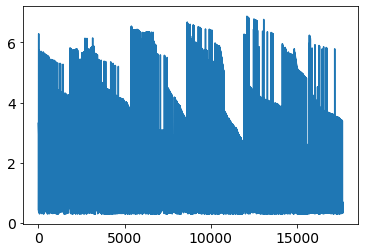

In [18]:
plt.plot(pos_err_store)

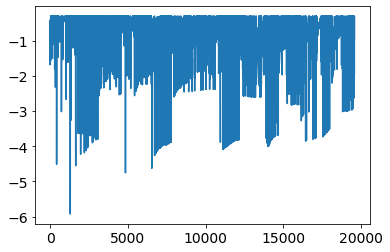

In [19]:
plt.plot(neg_err_store)

In [20]:
ltm.count()

1134

In [21]:
# plt.savefig("{0}5.png".format(accuracy))

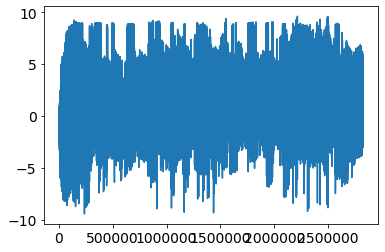

In [22]:
plt.plot(total_error)

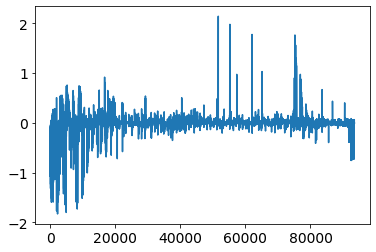

In [23]:
plt.plot(total_goal_error)

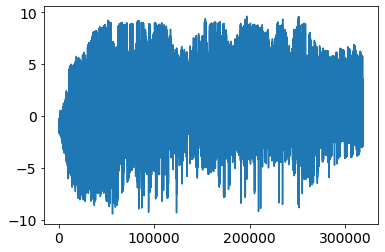

In [24]:
plt.plot(switch_error)

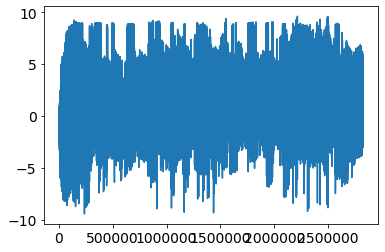

In [25]:
plt.plot(norm_error)